# This Notebook Presents Results and Visualizations for SAE based on MF architecture- for Last.FM dataset

In [ ]:
from typing import Callable, Any

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import os
import numpy as np
import scipy
from scipy.sparse import csr_matrix
from pathlib import Path
from torch.utils.data import DataLoader
export_dir = os.getcwd()
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import plot
import random
import math
import heapq
from scipy.special import expit  # Sigmoid function
import itertools
from IPython.display import Latex, display
import pickle
from scipy.stats import kendalltau
import optuna
import warnings

# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Set to None to display all rows and columns
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

test_flag = 1

In [ ]:
pip install ipynb

In [ ]:
from ipynb.fs.defs.utils import *
from ipynb.fs.defs.data_processing import *
from ipynb.fs.defs.models import *
from ipynb.fs.defs.training import *

# General Data

## Latent representations from recommender- input

In [ ]:
# Load the dataset from the .csv file
# df = pd.read_csv(Path(export_dir,'interaction_embeddings.csv')) # based on the training dataset only
df_item_emb = pd.read_csv(Path(export_dir,'res_csv/lastFM/mf/items_embeddings_mf_model.csv'))
df_item_emb1 = pd.read_csv(Path(export_dir,'res_csv/lastFM/mf/items_embeddings_mf_model_Windex.csv'))
df_user_emb = pd.read_csv(Path(export_dir,'res_csv/lastFM/mf/users_embeddings_mf_model.csv'))
df_b_i_emb = pd.read_csv(Path(export_dir,'res_csv/lastFM/mf/b_i_mf_model.csv'))
df_b_u_emb = pd.read_csv(Path(export_dir,'res_csv/lastFM/mf/b_u_mf_model.csv'))


# CONVERT TO TENSORS
dataset_items = torch.tensor(df_item_emb.values, dtype=torch.float32)
dataset_users = torch.tensor(df_user_emb.values, dtype=torch.float32)
dataset_bu = torch.tensor(df_b_u_emb.values, dtype=torch.float32)
dataset_bi = torch.tensor(df_b_i_emb.values, dtype=torch.float32)


interaction_embeddings = dataset_users

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim_matrix = cosine_similarity(df_item_emb)
df_cosine_sim_matrix = pd.DataFrame(cosine_sim_matrix)
df_cosine_sim_matrix

# General data analysis:

## Separation into train and test sets:


In [ ]:
test_subset_users = random.sample(list(df_user_emb.index), k=math.floor(df_user_emb.shape[0]*0.2))
test_subset_items = random.sample(list(df_item_emb.index), k=math.floor(df_item_emb.shape[0]*0.2))

In [ ]:
train_subset_users = [i for i in df_user_emb.index if i not in test_subset_users]

interaction_embeddings = dataset_users[train_subset_users]


optimizing SAE params using optuna

In [ ]:
def objective(trial):
    seed = 42
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    #  Suggest hyperparameters
    mse_w   = trial.suggest_loguniform('mse_weight', 1e-1, 1e1)    # 0.1 -> 10
    l1_w    = trial.suggest_loguniform('l1_weight', 1e-5, 1e0)    # 1e‑5 -> 1
    kl_w    = trial.suggest_loguniform('kl_weight', 1e-5, 1e0)   # 1e‑5 -> 1
    inner_product_weight = trial.suggest_uniform('inner_product_weight', 0.0, 20.0) # 0 -> 20


    model = train_autoencoder(
        interaction_embeddings,
        dataset_items,
        test_data=dataset_users[test_subset_users],
        input_dim=100,
        latent_dim=70,
        num_epochs=30,
        batch_size=256,
        learning_rate=1e-3,
        mse_weight = mse_w,
        l1_weight  = l1_w,
        kl_weight  = kl_w,
        inner_product_weight=inner_product_weight
    )


    # Extract the item latents and compute MS Score
    _,latents_items,_ = model(dataset_items)
    avg_ms = ms_score_new(df_cosine_sim_matrix, latents_items)

    return float(avg_ms)

# Create and run the study
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42)
)
study.optimize(objective, n_trials=20)

df_trials = study.trials_dataframe()

df_sorted = df_trials.sort_values("value", ascending=False)
df_sorted.to_csv(export_dir+'rec_csv/lastFM/sae_mf_params_optuna.csv', index=False)

df_trials

optimizing SAE matryoshka params using optuna

In [ ]:
g = torch.Generator().manual_seed(42)
g_items = torch.Generator().manual_seed(42)

user_tensor = torch.tensor(mf_recommender.P, dtype=torch.float32)
item_tensor = torch.tensor(mf_recommender.Q, dtype=torch.float32)

user_loader = DataLoader(interaction_embeddings, batch_size=256, shuffle=True, generator = g)
item_loader = DataLoader(item_tensor, batch_size=256, shuffle=True, generator = g_items)


user_tensor = torch.tensor(mf_recommender.P, dtype=torch.float32)
item_tensor = torch.tensor(mf_recommender.Q, dtype=torch.float32)

user_loader = DataLoader(interaction_embeddings, batch_size=256, shuffle=True, generator = g)
item_loader = DataLoader(item_tensor, batch_size=256, shuffle=True, generator = g)


In [ ]:
def objective(trial):
    # 1) Suggest hyperparameters
    seed = 42
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    mse_w   = trial.suggest_loguniform('mse_weight', 1e-1, 1e1)    # 0.1 ->→ 10
    l1_w    = trial.suggest_loguniform('l1_weight', 1e-5, 1e0)    # 1e‑5 -> 1
    kl_w    = trial.suggest_loguniform('kl_weight', 1e-5, 1e-1)   # 1e‑5 -> 0.1
    inner_weight = trial.suggest_uniform('inner_weight', 0.0, 20.0) # 0 -> 20

    K = 80 #user_tensor.shape[1]
    prefixes = [K // 4, K // 2, K]
    sae_shared = MatryoshkaAutoencoder(latent_dim=K, input_dim=100, group_sizes=prefixes)

    train_matryoshka(
        sae_shared,
        user_loader,
        item_loader,
        num_epochs=30,
        lr=1e-3,
        mse_weight = mse_w,
        l1_weight=l1_w,
        kl_weight = kl_w,
        inner_weight=inner_weight
    )


    # Extract the item latents and compute MS Score
    _,latents_items,_ = sae_shared(dataset_items)  # assume shape [N_items, latent_dim]
    avg_ms = ms_score_new(df_cosine_sim_matrix, latents_items)

    return float(avg_ms)

# Create and run the study
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42)
)
study.optimize(objective, n_trials=50)

df_trials = study.trials_dataframe()

df_sorted = df_trials.sort_values("value", ascending=False)
df_sorted.to_csv(OUTPUTS_DIR+'rec_csv/lastFM/sae_matryoshka_params_optuna.csv', index=False)

df_trials

train a model:

In [ ]:
test_flag=1
autoencoder=train_autoencoder(interaction_embeddings, dataset_items,dataset_users[test_subset_users], input_dim=dataset_users.shape[1], latent_dim=70)

or- loading the model

In [ ]:
model_name = 'lastFM_SAE_MF'
# Initialize a new model instance with the same architecture
autoencoder = torch.load(Path(export_dir,f'models/lastFM/{model_name}.pth'), weights_only  = False)

# test_subset = autoencoder.test_subset_ind
test_subset_users = autoencoder.test_subset_users_ind
test_subset_items = autoencoder.test_subset_items_ind


train_subset_users = [i for i in df_user_emb.index if i not in test_subset_users]

interaction_embeddings=dataset_users[train_subset_users]


# Evaluation

In [ ]:
latents_pre_act_items, latents_items, reconstructions_items = autoencoder(dataset_items)

In [ ]:
latents_pre_act_users, latents_users, reconstructions_users = autoencoder(dataset_users)

In [ ]:
latents_items_numpy_array = latents_items.detach().numpy()
latents_items_df = pd.DataFrame(latents_items_numpy_array)
latents_items_df.index = user_artist_matrix.columns

In [ ]:
latents_users=latents_users.detach().clone()
latents_items=latents_items.detach().clone()

reconstructions_users=reconstructions_users.detach().clone()
reconstructions_items=reconstructions_items.detach().clone()

avg_ms_score= ms_score_new(df_cosine_sim_matrix, latents_items)

users_ind= autoencoder.test_subset_users_ind
lists_compare_table = pd.DataFrame(0, index=users_ind, columns=['RBO Score', 'Kendall Tau Score'])

for user in lists_compare_table.index:

  top_rec_user_id_orig = recommend_pq(user, dataset_users, dataset_items, 30)
  top_rec_user_id_rec  = recommend_pq(user, reconstructions_users, reconstructions_items, 30)    # top_rec_user_id_rec = rec_gen(movie_num, user, df_b_u_emb, df_b_i_emb, a_, b_)

  lists_compare_table.loc[user,'RBO Score'] = rbo(top_rec_user_id_orig, top_rec_user_id_rec)
  lists_compare_table.loc[user,'Kendall Tau Score'] = kendall_tau(top_rec_user_id_orig, top_rec_user_id_rec)

print(f'{round(float(lists_compare_table.mean().iloc[0]),6)} | {round(float(lists_compare_table.mean().iloc[1]),6)}')
print(f'averaged MS score: {avg_ms_score}')

# Latent Representation Analysis

# Related to items:

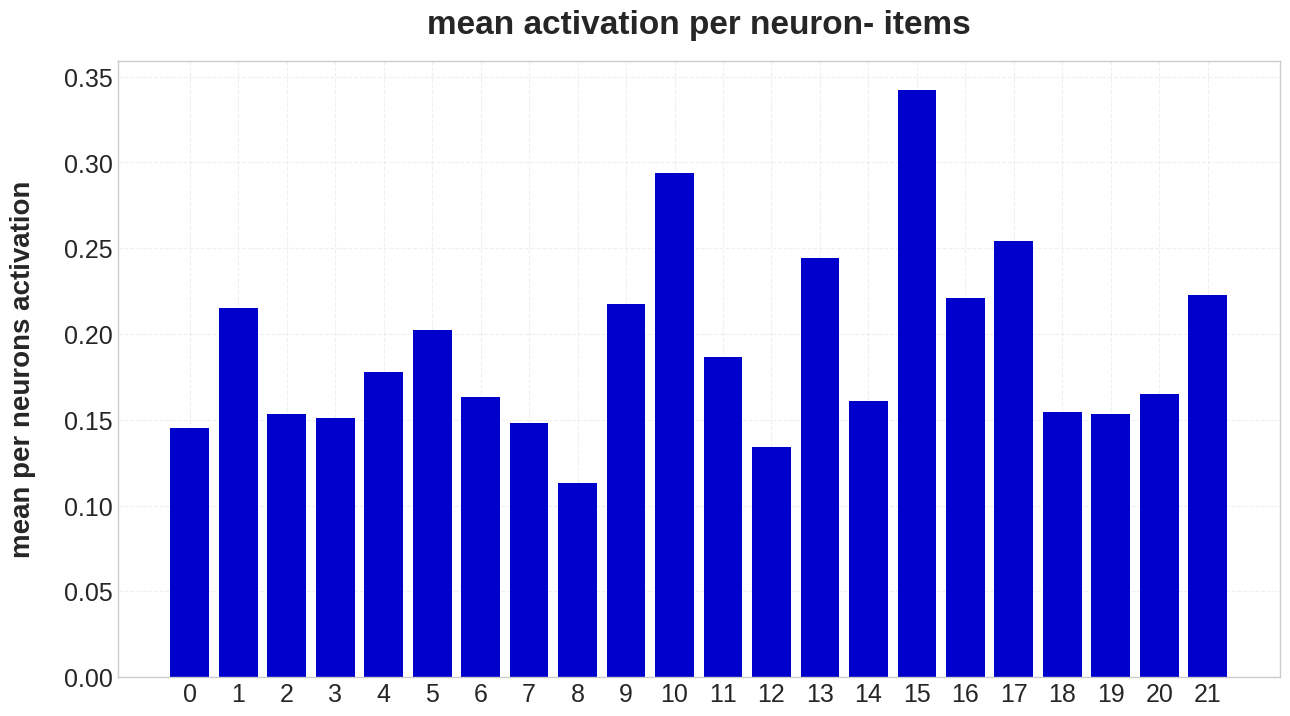

In [ ]:
# averaged activation on every neuron:
plt.style.use('seaborn-v0_8-whitegrid')

latents_items_numpy_array = latents_items.detach().numpy()
latents_items_df = pd.DataFrame(latents_items_numpy_array)
latents_items_df.index = user_artist_matrix.columns

# latents_df.mean()

plt.figure(figsize=(15, 8))
plt.bar(latents_items_df.columns, latents_items_df.mean(), color='mediumblue')
plt.title(f'mean activation per neuron- items', pad=20,weight='bold',fontsize=24)
plt.ylabel('mean per neurons activation', labelpad=20,weight='bold',fontsize=20)
plt.grid(True, linestyle='--', alpha=0.3)

plt.xticks(latents_items_df.columns,fontsize=18)
plt.yticks(fontsize=18)

plt.show()



# Testing K most dominant movies per neuron
i.e.- topK movies that yielded the highest activation per neuron.

In [ ]:
K = 50
highly_activate_movies2neurons= pd.DataFrame(0,index=latents_items_df.columns,columns =range(0,K))
for neuron in latents_items_df.columns:
  highly_activate_movies2neurons.loc[neuron,:] = latents_items_df.loc[:,neuron].nlargest(ITEMS_lastFM)[0:K].index

In [ ]:
size = K

dominant_genre = {}
for neuron in latents_items_df.columns:

  activated_per_neuron = df_artists_tags.loc[highly_activate_movies2neurons.iloc[neuron,:],:]
  norm_activated_per_neuron = activated_per_neuron.sum()/size

  plt.figure(figsize=(30, 8))
  plt.title(f'Neuron {neuron} - Genre Wise Distribution of the top{size} Dominant Artists', pad=20,weight='bold',fontsize=24)
  plt.xlabel('Genres', labelpad=20,weight='bold',fontsize=20)

  plt.bar(genres, norm_activated_per_neuron[genres], color='tan',edgecolor = 'darkgoldenrod', hatch = '//')
  plt.ylabel('Items Percentage', labelpad=20,weight='bold',fontsize=20)
  plt.xticks(rotation=90, fontsize=18)
  plt.yticks(fontsize=18)
  plt.grid(True, linestyle='--', alpha=0.5)



In [ ]:
activated_per_neuron = df_artists_tags.loc[highly_activate_movies2neurons.iloc[1,:],:]
activated_per_neuron.sum()

## Quantitative results

PURITY

In [ ]:
K = 20
highly_activate_movies2neurons= pd.DataFrame(0,index=latents_items_df.columns,columns =range(0,K))
for neuron in latents_items_df.columns:
  highly_activate_movies2neurons.loc[neuron,:] = latents_items_df.loc[:,neuron].nlargest(ITEMS)[0:K].index

In [ ]:
neuron = 11

tar_genre =['metal','melodic_death_metal','death_metal','power_metal','progressive_metal','symphonic_metal'] #['folk']#['rock','indie_rock']#['hardcore', 'metalcore','screamo','post_hardcore']#['electronic']#['pop','dance','female_vocalists','hip_hop']#['electronic','dance', 'trance']#['country']#['reggae', 'folk', 'ska']
a=df_artists_tags.loc[highly_activate_movies2neurons.iloc[neuron,:],tar_genre]
purity = a.sum(axis=1)
(purity>0).sum()/K

monosemanticity score:

In [ ]:
ms_score_all_neurons(df_cosine_sim_matrix, latents_items)

Analyze monosemantic neurons

In [ ]:
neuro = 11
artist_clusters_df1 = top_tags_per_artist[['artist', 'tags']]
artist_clusters_df1 = artist_clusters_df1.loc[highly_activate_movies2neurons.iloc[neuro,:],:]
merged_df_ = artist_clusters_df1.join(most_popular['rank']*100/ITEMS_lastFM, how='left')

num_per_genre_recommended = df_artists_tags.loc[highly_activate_movies2neurons.iloc[neuro,:],:].sum()

plt.figure(figsize=(30,10))
(num_per_genre_recommended/K).plot(kind='bar', color='tan')
plt.title('Genre-wise activation profiles')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90,fontsize=14)
plt.grid(True)
plt.show()

merged_df_.iloc[0:20]

In [ ]:
neuro = 44
artist_clusters_df1 = top_tags_per_artist[['artist', 'tags']]
artist_clusters_df1 = artist_clusters_df1.loc[highly_activate_movies2neurons.iloc[neuro,:],:]
merged_df_ = artist_clusters_df1.join(most_popular['rank']*100/ITEMS_lastFM, how='left')

num_per_genre_recommended = df_artists_tags.loc[highly_activate_movies2neurons.iloc[neuro,:],:].sum()

plt.figure(figsize=(30,10))
(num_per_genre_recommended/K).plot(kind='bar', color='tan')
plt.title('Genre-wise activation profiles')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90,fontsize=14)
plt.grid(True)
plt.show()

merged_df_.iloc[0:20]

In [ ]:
neuro = 5
artist_clusters_df1 = top_tags_per_artist[['artist', 'tags']]
artist_clusters_df1 = artist_clusters_df1.loc[highly_activate_movies2neurons.iloc[neuro,:],:]
merged_df_ = artist_clusters_df1.join(most_popular['rank']*100/ITEMS_lastFM, how='left')

num_per_genre_recommended = df_artists_tags.loc[highly_activate_movies2neurons.iloc[neuro,:],:].sum()

plt.figure(figsize=(30,10))
(num_per_genre_recommended/K).plot(kind='bar', color='tan')
plt.title('Genre-wise activation profiles')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90,fontsize=14)
plt.grid(True)
plt.show()

merged_df_.iloc[0:20]

## Other concepts:

popularity pattern

In [ ]:
pop_rank_df = pd.DataFrame(0,index=latents_items_df.columns,columns =range(0,50))
for neuron in latents_items_df.columns:
  a1=latents_items_df.loc[:,neuron].nlargest(ITEMS_lastFM)[0:50]
  for id, movie in enumerate(a1.index):
    pop_rank_df.loc[neuron,id]= np.where(num_users_per_artist_sort.index == a1.index[id])[0][0]
# pop_rank_df.mean(axis=1)
pop_rank_df.mean(axis=1)/ITEMS_lastFM

{'60': 41, '70': 62, '80': 199, '90': 782, '2000': 0}

-

# Further Latent Analysis and Manipulations:


Activate one neuron in Latent representation

In [ ]:
movie = 1566
movie_ind = np.where(ratings_matrix.columns == movie)[0][0]

In [ ]:
x = np.array(np.array(dataset_items[1016]))


# autoencoder == self in the original code
x, info = autoencoder.preprocess(x)
cuur_latents_pre_act = autoencoder.encode_pre_act(x)
curr_latents = autoencoder.activation(cuur_latents_pre_act)
curr_latents = torch.zeros_like(curr_latents)

neuron_one = 68
level = 2
curr_latents[neuron_one]=level
recons_unique = autoencoder.decode(curr_latents, info)

#-----------------------------------------------------------------------------------------------------------------------------------


_, editeEncOut_recons_latents, _ = autoencoder(np.array(recons_unique.detach().numpy()))
df_editeEncOut_recons_latents_post_enc = pd.DataFrame(editeEncOut_recons_latents.detach().numpy())

df_recons_edited = pd.DataFrame(recons_unique.detach().numpy())

score_low = {}
score_high = {}


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

# First bar chart: Mean activation per neuron
ax1.bar(latents_items_df.columns, df_editeEncOut_recons_latents_post_enc[0], color='tan')
ax1.bar(latents_items_df.columns+0.1, latents_items_df.mean(), color='blue',width=0.1)

ax1.set_title(f'Activation of recons of edited latents into enc, per Neuron',fontsize=14, weight='bold')
ax1.set_xlabel('Neurons',fontsize=17, weight='bold')
ax1.set_ylabel('Mean Neuron Activation',fontsize=17, weight='bold')
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.set_xticks(range(len(latents_items_df.columns)))
ax1.set_xticklabels(latents_items_df.columns, rotation=90,fontsize=15)
ax1.tick_params(axis='y', labelsize=15)



normalized_activation = df_editeEncOut_recons_latents_post_enc[0] / latents_items_df.mean()

ax2.bar(latents_items_df.columns, normalized_activation, color='tan')
ax2.set_title(f'Activation of recons of edited latents into enc, per Neuron',fontsize=14, weight='bold')
ax2.set_xlabel('Neurons',fontsize=14, weight='bold')
ax2.set_ylabel('Normalized Activation- by mean',fontsize=14, weight='bold')
ax2.grid(True, linestyle='--', alpha=0.5)
ax2.set_xticks(range(len(latents_items_df.columns)))
ax2.set_xticklabels(latents_items_df.columns, rotation=90,fontsize=15)
ax2.tick_params(axis='y', labelsize=15)

plt.tight_layout()
plt.show()



#-----------------------------------------------------------------------------------------------------------------------------------


movie_num = 10
movie_num_test = 10

cosine_res = {}

test_mod_recons_embeddings = recons_unique
df_test_mod_recons_embeddings = pd.DataFrame(test_mod_recons_embeddings.detach().numpy())
magnitude_test_mod_recons_embeddings = np.linalg.norm(df_test_mod_recons_embeddings) ## TODO- maybe [0]

for i, movie_id in enumerate(user_artist_matrix.columns):
  # if i in train_subset:
    curr_dot_product = np.dot(df_item_emb1.loc[movie_id],df_test_mod_recons_embeddings[0])
    curr_magnitude = np.linalg.norm(df_item_emb1.loc[movie_id])
    curr_cosine_similarity = curr_dot_product / (magnitude_test_mod_recons_embeddings * curr_magnitude)

    cosine_res[movie_id] = curr_cosine_similarity

max_key = max(cosine_res, key=cosine_res.get)
genres_test_mod_recons_embeddings = df_artists_tags.columns[(np.where(df_artists_tags.loc[max_key]==1)[0])].tolist()
topK_test_mod_recons_embeddings = heapq.nlargest(movie_num, cosine_res.items(), key=lambda x: x[1])


#-----------------------------------------------------------------------------------------------------------------------------------

table1 = pd.DataFrame(0, index=range(movie_num), columns=['movie', 'name','rank'])
for i in table1.index:
  table1.iloc[i,0] =  topK_test_mod_recons_embeddings[i][0]
  table1.iloc[i,1] =  str(df_artists_tags.columns[(np.where(df_artists_tags.loc[topK_test_mod_recons_embeddings[i][0]]==1)[0])].tolist())
  table1.iloc[i,2] =  most_popular.loc[topK_test_mod_recons_embeddings[i][0],'rank']/2277


# #-----------------------------------------------------------------------------------------------------------------------------------



a=[topK_test_mod_recons_embeddings[i][0] for i in range(len(topK_test_mod_recons_embeddings))]
b = (df_artists_tags.loc[a])


plt.figure(figsize=(20, 5))
numerator = (df_artists_tags.loc[a].sum(axis=0)) if 'Cluster' in df_artists_tags.columns else (df_artists_tags.loc[a].sum(axis=0))

plt.bar(genres, numerator/movie_num, color='tan')
plt.title(f'Genres of {movie_num} most similar movies',fontsize=16, weight='bold')
plt.xlabel('genres',fontsize=15, weight='bold')
plt.ylabel('number of movies per genre',fontsize=17, weight='bold')
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)

plt.grid(True, linestyle='--', alpha=0.5)


# #--------------------------------------------------------------------------------------------------------------------------------------





# table1_Wname
table1

-

-

-

In [ ]:
N=20

# USE CASES

# user case 1- Modify Item Latent Representation

## Item Exposure to new audience-


In [ ]:
'''find the group'''
'''list of users that listened to artists of certain genre, sorted by the number of
artists of the certain genre wrt the total number of artists ranked by the user'''

usersGroup = generate_users_test_group('pop', N, autoencoder)

usersGroup

level: 0
level: 2
level: 3
level: 4
level: 5
level: 6
level: 7
level: 8
level: 9


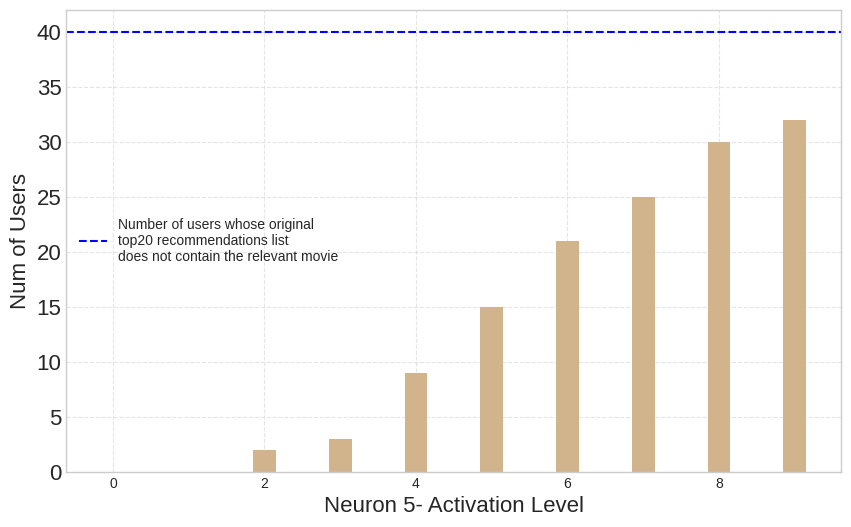

In [ ]:
numUsersTotopk = []
numUsersOuttopk_orig = []
movie_num = ITEMS_lastFM
test_artist = 'Bob Marley & The Wailers'
ind_movie = np.where(df_item_emb1.index==test_artist)[0][0]
th = 50
neuron = 8


neuron_levels = [0,1,2,3,4,5,6,7,8]

'''what place 'test_artist' has among all recommendations of all relevant users '''
table = pd.DataFrame(0, index=range(len(usersGroup.index)), columns=['user', 'orig rec rank']+[f'new rec rank_lev{lev}' for lev in neuron_levels[1:]])



for level in neuron_levels:
  print(f'level: {level}')

  for ind,user_movie_test in enumerate(usersGroup.index):

    movie_act =  latents_item_df.loc[test_artist,:]
    movie_act_new = movie_act.copy(deep=True)
    movie_act_new.iloc[neuron] = level

    x = np.array(np.array(dataset_items[ind_movie]))
    x, info = autoencoder.preprocess(x)
    curr_latents = torch.from_numpy(movie_act_new.values)#latents_item[ind_movie]
    recons = autoencoder.decode(curr_latents,info)

    df_item_emb_copy= df_item_emb.copy(deep=True)
    df_item_emb_copy.iloc[ind_movie,:]=pd.DataFrame(recons.detach().numpy()).iloc[:,0]


    if level == 0 :
      top_rec_user_id_orig = recommend_pq_all(user_movie_test,dataset_users,df_item_emb_copy, movie_num)

      table1_rec_Wname_orig = table_maker_new(movie_num, top_rec_user_id_orig, df_tags)

    top_rec_user_id_new = recommend_pq_all(user_movie_test, dataset_users,df_item_emb_copy, movie_num)

    table1_rec_Wname_new = table_maker_new(movie_num, top_rec_user_id_new, df_tags)


    #--------------------------------------------------------------------------------------

    table.iloc[ind,0] = user_movie_test
    if level == 0 :
      table.iloc[ind,1] = np.where(table1_rec_Wname_orig.iloc[:,1]==ind_movie)[0][0]
    table.iloc[ind,2] = np.where(table1_rec_Wname_new.iloc[:,1]==ind_movie)[0][0]

  # print(f'for debug- level: {level}')
  to_top50 = []
  remain_top50 = []
  from_top50 = []
  count_in_top50_orig = 0
  count_out_top50_orig = 0
  for i in table.index:
    if table.iloc[i,1]>th:
      count_out_top50_orig+=1
      # ease on harder mission
      if table.iloc[i,2] <= th+10:
        to_top50.append(table['user'][i])


    else: continue

  numUsersOuttopk_orig.append(count_out_top50_orig)
  numUsersTotopk.append(len(to_top50))




fig, (ax1) = plt.subplots(1, 1, figsize=(10, 6))

ax1.bar(neuron_levels, numUsersTotopk, color='tan',width = 0.3)
ax1.axhline(numUsersOuttopk_orig[0], color='blue', linestyle='--')
ax1.set_xlabel('Neuron 5- Activation Level',fontsize=16)
ax1.set_ylabel('Num of Users',fontsize=16)
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.legend(['Number of users whose original\ntop50 recommendations list\ndoes not contain the relevant movie'
            ],loc ='center left', fancybox=False)

ax1.tick_params(axis='y', labelsize=16)



In [ ]:
numUsersTotopk1 = numUsersTotopk.copy()

In [ ]:
numUsersTotopk2 = numUsersTotopk.copy()

In [ ]:
numUsersTotopk3 = numUsersTotopk.copy()

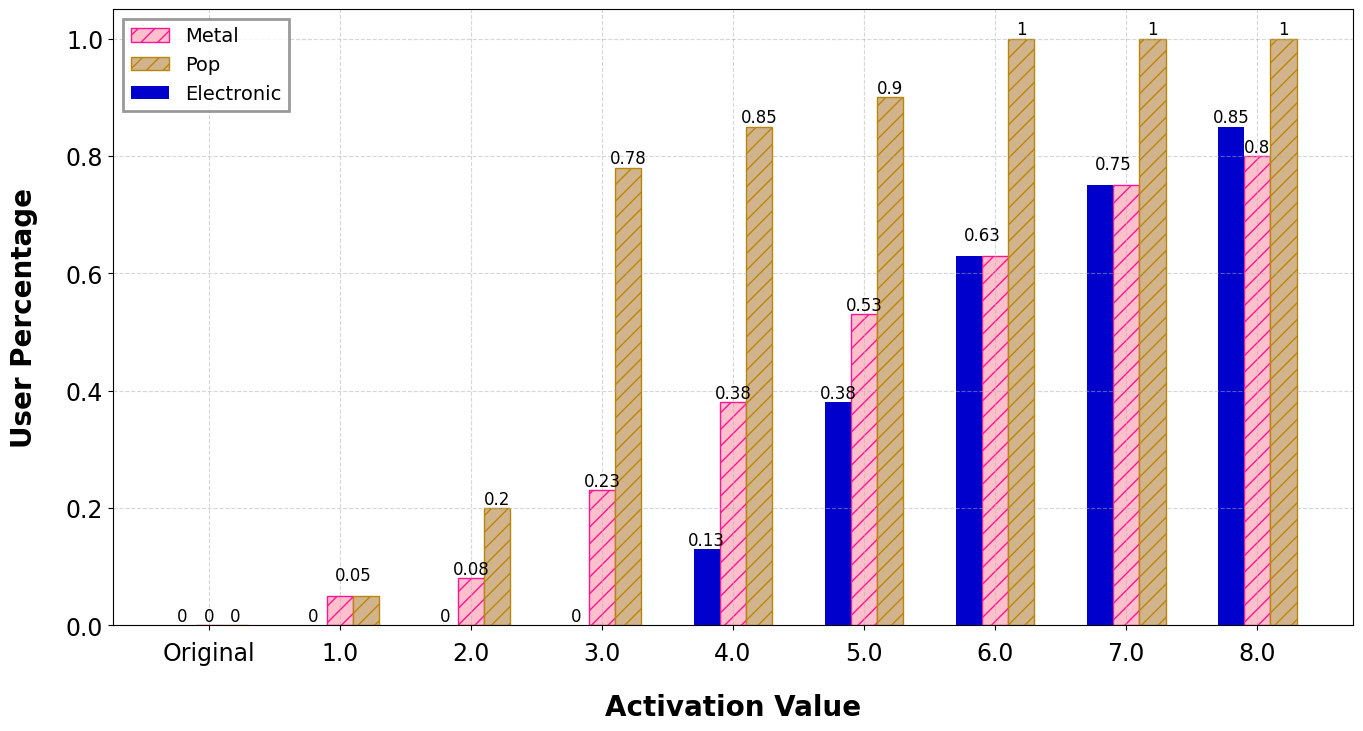

In [ ]:
# fig, ax1 = plt.subplots(1, 1, figsize=(16, 8))

# concepts = ['Metal', 'Pop','Electronic']
# neuron_levels = np.array([0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0])
# width = 0.2

# vals_metal      = np.array(numUsersTotopk1)
# vals_pop        = np.array(numUsersTotopk2)
# vals_electronic = np.array(numUsersTotopk3)

# x_e = neuron_levels
# x_m = neuron_levels + width
# x_p = neuron_levels + 2*width

# bars_m = ax1.bar(x_m, vals_metal,      color='pink',  width=width, hatch='//', edgecolor='deeppink',      label='Metal')
# bars_p = ax1.bar(x_p, vals_pop,        color='tan',   width=width, hatch='//', edgecolor='darkgoldenrod', label='Pop')
# bars_e = ax1.bar(x_e, vals_electronic, color='mediumblue', width=width, label='Electronic')


# xtick_pos = x_e + width
# xtick_lbl = neuron_levels.astype(object).tolist()
# xtick_lbl[0] = 'Original'

# ax1.set_xticks(xtick_pos)
# ax1.set_xticklabels(xtick_lbl, fontsize=17)
# ax1.tick_params(axis='x', pad=8)


# labels_m = [f'{v:.3g}' if v >= 0 else '' for v in vals_metal]
# labels_p = [f'{v:.3g}' if v >= 0 else '' for v in vals_pop]
# labels_e = [f'{v:.3g}' if v >= 0 else '' for v in vals_electronic]

# overlap_x_vals = [6, 7]
# for xv in overlap_x_vals:
#     idx = np.where(neuron_levels == xv)[0][0]
#     labels_m[idx] = ''
#     labels_e[idx] = ''
#     x_shared = 0.5*(x_m[idx] + x_e[idx])
#     y_shared = max(vals_metal[idx], vals_electronic[idx])
#     ax1.text(x_shared, y_shared + 0.02, f'{y_shared:.3g}', ha='center', va='bottom', fontsize=12)

# overlap_x_vals = [1]
# for xv in overlap_x_vals:
#     idx = np.where(neuron_levels == xv)[0][0]
#     labels_p[idx] = ''
#     labels_m[idx] = ''
#     x_shared = 0.5*(x_m[idx] + x_p[idx])
#     y_shared = max(vals_metal[idx], vals_pop[idx])
#     ax1.text(x_shared, y_shared + 0.02, f'{y_shared:.3g}', ha='center', va='bottom', fontsize=12)

# ax1.bar_label(bars_m, labels=labels_m, fontsize=12)
# ax1.bar_label(bars_p, labels=labels_p, fontsize=12)
# ax1.bar_label(bars_e, labels=labels_e, fontsize=12)

# ax1.set_xlabel('Activation Value', labelpad=20, weight='bold', fontsize=20)
# ax1.set_ylabel('User Percentage', labelpad=20, weight='bold', fontsize=20)
# ax1.grid(True, linestyle='--', alpha=0.5)
# yticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
# ax1.set_yticks(yticks)
# ax1.set_yticklabels([f'{t:.1f}' for t in yticks], fontsize=17)


# leg = ax1.legend(['Metal', 'Pop','Electronic'],
#                  loc='upper left', fontsize=14, fancybox=False, frameon=True)
# frame = leg.get_frame()
# frame.set_edgecolor('grey')
# frame.set_linewidth(2)

# plt.show()


In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(16, 8))

concepts = ['Metal', 'Pop','Electronic']
neuron_levels = [0,1,2,3,4,5,6,7,8]


r = ax1.bar([0.2,1.2,2.2, 3.2, 4.2, 5.2, 6.2, 7.2, 8.2],numUsersTotopk1, color='pink', width=0.2, hatch = '//',edgecolor='deeppink')
ax1.bar_label(r, fontsize=12)

r1 = ax1.bar([0.4,1.4,2.4, 3.4, 4.4, 5.4, 6.4, 7.4, 8.4], numUsersTotopk2, color='tan', width=0.2, hatch = '//',edgecolor='darkgoldenrod')
ax1.bar_label(r1, fontsize=12)


r2 = ax1.bar(neuron_levels, numUsersTotopk3, color='mediumblue', width=0.2)
ax1.bar_label(r2, fontsize=12)

ax1.set_xlabel('Neuron Activation Value', labelpad=20, weight='bold', fontsize=20)
ax1.set_ylabel('User Percentage', labelpad=20, weight='bold', fontsize=20)
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax1.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=17)

# Prepare custom x-axis labels
label_x = neuron_levels.copy()
label_x[0] = 'Original'

# Set the x-tick positions and labels only once:
ax1.set_xticks([0,1,2, 3, 4, 5, 6,7,8])
ax1.set_xticklabels(label_x, fontsize=17)
ax1.tick_params(axis='both', labelsize=17 )

leg = ax1.legend(['Metal', 'Pop','Electronic'],
                 loc='upper left', fontsize=14, fancybox=False, frameon=True)
frame = leg.get_frame()
frame.set_edgecolor('grey')
frame.set_linewidth(2)

plt.show()


# Latent user representation intervention

Generate new audience

In [ ]:
'''find the group'''
'''list of users that watched movies of certain genre, sorted by the number of
movies of the certain genre wrt the total number of movies ranked by the user'''

usersGroup = generate_users_test_group('metal', N, autoencoder)
usersGroup

Examine one users' latent manipulation's effect

In [ ]:
movie_num = 30

top_rec_user_id = recommend_pq_all(user, dataset_users, dataset_items, movie_num)
# As a list of (row_idx, column_name) tuples
a = df_artists_tags.iloc[top_rec_user_id,:].sum()

plt.figure(figsize=(16, 6))
plt.bar(genres, a, color='tan')
plt.title(f'{movie_num} recommended movies for user {user}',fontsize=18, weight='bold')
plt.ylabel('num of movies',fontsize=17, weight='bold')
plt.xlabel('genres',fontsize=17, weight='bold')
# ax1.axhline(y=latents_df.mean().iloc[index], color='blue', linestyle='--')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=90,fontsize=15)
plt.yticks(fontsize=15)
plt.show()

#------------------------------------------------------------------------------

table1_rec_Wname = table1_Wname = table_maker_new(movie_num, top_rec_user_id, df_tags, num_users_per_artist_sort)


table1_rec_Wname

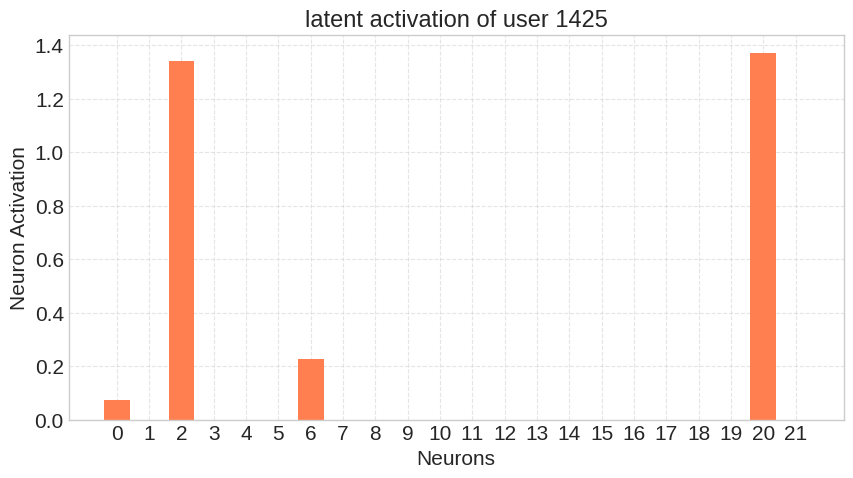

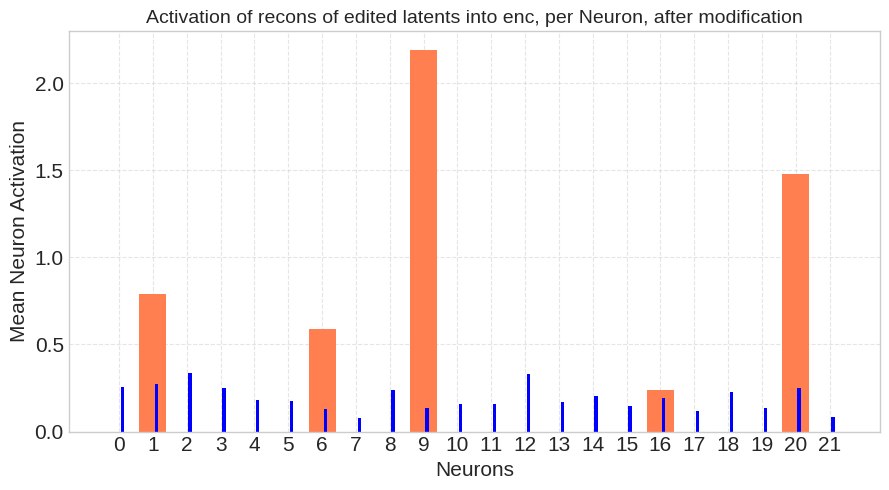

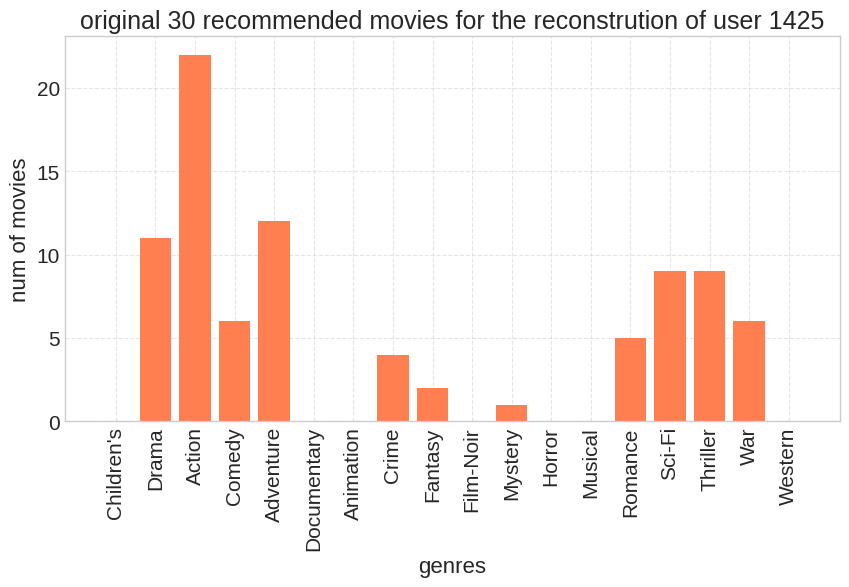

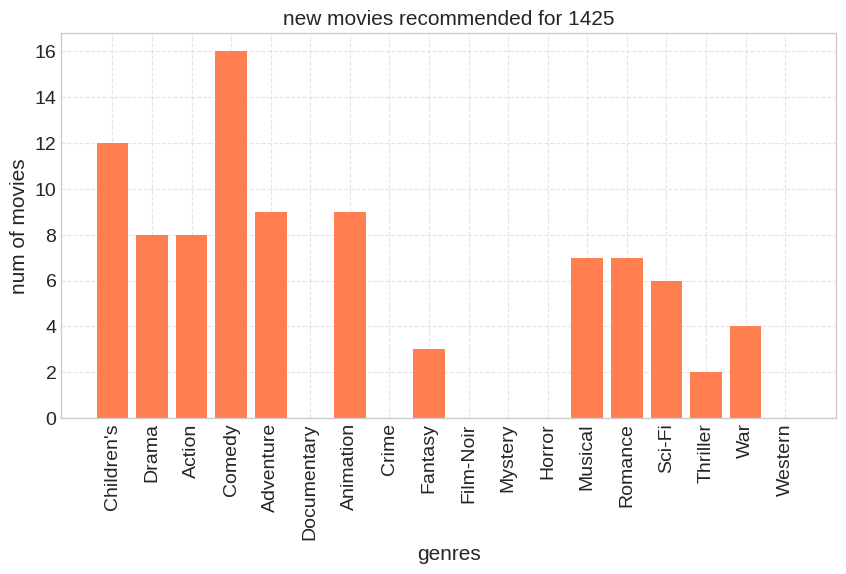


list of recommendations to the reconstruction of the modified latent representation



,movie,name,genres,pop rank
0,364,"Lion King, The (1994)","[""Children's"", 'Animation', 'Musical']",155
1,588,Aladdin (1992),"[""Children's"", 'Comedy', 'Animation', 'Musical']",96
2,1,Toy Story (1995),"[""Children's"", 'Comedy', 'Animation', 'movie_id']",29
3,595,Beauty and the Beast (1991),"[""Children's"", 'Animation', 'Musical']",182
4,3114,Toy Story 2 (1999),"[""Children's"", 'Comedy', 'Animation']",58
5,2628,Star Wars: Episode I - The Phantom Menace (1999),"['Action', 'Adventure', 'Fantasy', 'Sci-Fi']",21
6,260,Star Wars: Episode IV - A New Hope (1977),"['Action', 'Adventure', 'Fantasy', 'Sci-Fi']",1
7,2355,"Bug's Life, A (1998)","[""Children's"", 'Comedy', 'Animation']",47
8,34,Babe (1995),"[""Children's"", 'Drama', 'Comedy']",39
9,356,Forrest Gump (1994),"['Comedy', 'Romance', 'War']",25


In [ ]:
user = 20408#1088

# dataset_users = torch.tensor(df_user_emb.values, dtype=torch.float32)
latents_pre_act_all_usr, latents_all_usr, reconstructions_all_usr = autoencoder(dataset_users)

latents_numpy_array_all_usr = latents_all_usr.detach().numpy()
latents_df_all_usr = pd.DataFrame(latents_numpy_array_all_usr)
latents_df_all_usr.index = df_user_emb.index


recons_numpy_array_all_usr = reconstructions_all_usr.detach().numpy()
recons_df_all_usr = pd.DataFrame(recons_numpy_array_all_usr)
recons_df_all_usr.index = df_user_emb.index


# # get the relevant movie's input embeddings into the encoder
x = np.array(np.array(dataset_users[user]))
x, info = autoencoder.preprocess(x)
curr_latents = latents_all_usr[user]


#-----------------------------------------------------------------------------------------------------------------------------
plt.figure(figsize=(16, 6))
plt.bar(latents_df_all_usr.columns, curr_latents.detach().numpy(), color='tan')
plt.title(f'latent activation of user {user}',fontsize=17) #new user') # {user}')
plt.ylabel('Neuron Activation',fontsize=15)
plt.xlabel('Neurons',fontsize=15)
# ax1.axhline(y=latents_df.mean().iloc[index], color='blue', linestyle='--')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(latents_df_all_usr.columns,rotation=90,fontsize=15)
plt.yticks(fontsize=15)

plt.show()
#----------------------------------------------------------------------------------------------------------------------------
min_val = curr_latents.min()
max_val = curr_latents.max()
print(max_val,min_val )
curr_latents = (curr_latents - min_val) / (max_val - min_val + 1e-8)  # Normalize to [0,1]
curr_latents[5]=1


curr_latents= curr_latents * (max_val - min_val) + min_val

recons = autoencoder.decode(curr_latents,info)
df_user_emb_copy= dataset_users.clone()
df_user_emb_copy[user,:] = recons.detach()


_, editeEncOut_recons_latents, _ = autoencoder(np.array(recons.detach().numpy()))
df_editeEncOut_recons_latents_post_enc = pd.DataFrame(editeEncOut_recons_latents.detach().numpy())
#----------------------------------------------------------------------------------------------------------------------------


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

# First bar chart: Mean activation per neuron
ax1.bar(latents_df_all_usr.columns, editeEncOut_recons_latents.detach().numpy(), color='tan')
ax1.bar(latents_df_all_usr.columns+0.1, latents_all_usr.mean(axis=0).detach().numpy(), color='blue',width=0.1)

ax1.set_title(f'Activation of recons of edited latents into enc, per Neuron, after modification',fontsize=14)
ax1.set_xlabel('Neurons',fontsize=15)
ax1.set_ylabel('Mean Neuron Activation',fontsize=15)
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.set_xticks(range(len(latents_df_all_usr.columns)))
ax1.set_xticklabels(latents_df_all_usr.columns, rotation=90,fontsize=15)
ax1.tick_params(axis='y', labelsize=15)


normalized_activation = editeEncOut_recons_latents.detach().numpy() / latents_all_usr.detach().numpy().mean()

ax2.bar(latents_df_all_usr.columns, normalized_activation, color='tan')
ax2.set_title(f'Activation of recons of edited latents into enc, per Neuron, after modification',fontsize=14)
ax2.set_xlabel('Neurons',fontsize=15)
ax2.set_ylabel('Normalized Activation- by mean',fontsize=15)
ax2.grid(True, linestyle='--', alpha=0.5)
ax2.set_xticks(range(len(latents_df_all_usr.columns)))
ax2.set_xticklabels(latents_df_all_usr.columns, rotation=90,fontsize=15)
ax2.tick_params(axis='y', labelsize=15)

plt.tight_layout()
plt.show()



# #-----------------------------------------------------------------------------------------------------------------------------------
# '''recommendations for the reconstrucion of the user latent representation'''

plt.figure(figsize=(16, 6))
plt.bar(genres, a, color='tan')
plt.title(f'original {movie_num} recommended movies for the reconstrution of user {user}',fontsize=18)
plt.ylabel('num of movies',fontsize=16)
plt.xlabel('genres',fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=90,fontsize=15)
plt.yticks(np.arange(0, movie_num+5, 5), fontsize=14)
plt.show()
# #-----------------------------------------------------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------------------------------------------
'''recommendations after modifications to the user latent representation'''
movie_num = 30

top_rec_user_id = recommend_pq_all(user, df_user_emb_copy, dataset_items, movie_num)


a_new = df_artists_tags.iloc[top_rec_user_id,:].sum()


plt.figure(figsize=(16, 6))
plt.bar(genres, a_new, color='tan')
plt.title(f'new movies recommended for {user}',fontsize=15) #new user') # {user}')
plt.ylabel('num of movies',fontsize=15)
plt.xlabel('genres',fontsize=15)
# ax1.axhline(y=latents_df.mean().iloc[index], color='blue', linestyle='--')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(np.arange(0, movie_num+5, 5), fontsize=14)

plt.show()



'''list of recommendations to the reconstruction of the modified latent representation'''

table1_Wname = table_maker_new(movie_num, top_rec_user_id, df_tags, num_users_per_artist_sort)


#-------------------------------------------------------------------------------------------------
'''distribution of mean activations of dominant neurons in the representation, into genres'''

affective_neurons = []
for i in latents_df_all_usr.columns:
  if normalized_activation[i] > 1:
    affective_neurons.append(i)


table1_Wname

## Intervention-use case 2-  Nudging users toward new content

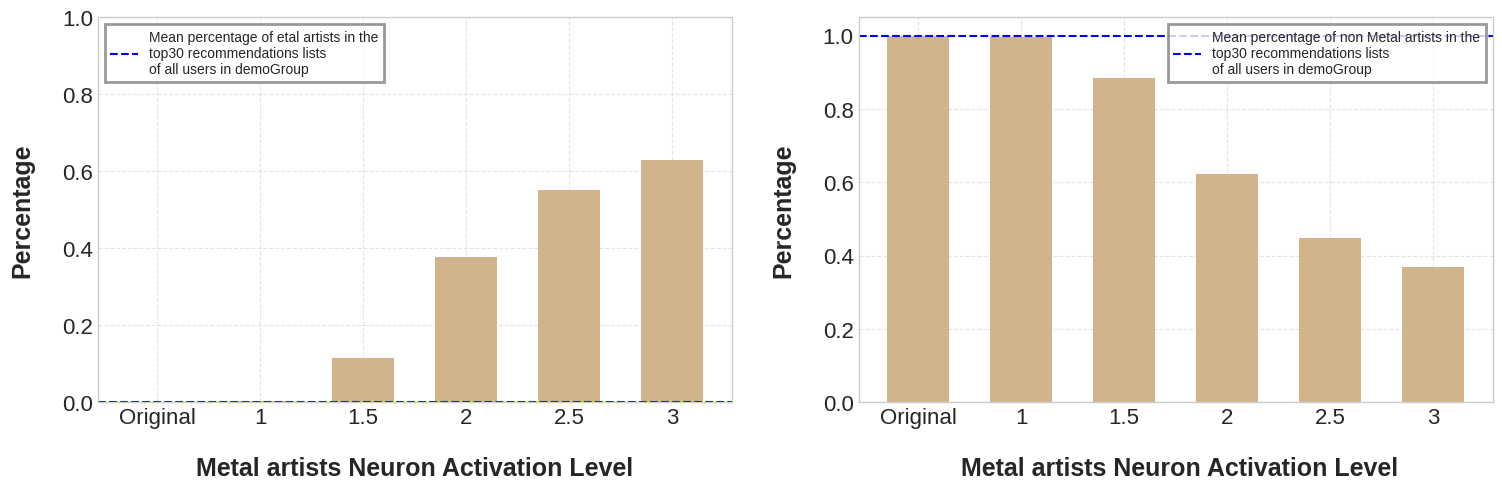

In [ ]:
movie_num2 = 30
meanTestGenreMoviesInTopK4DemoGroup_orig = []
meanTestGenreMoviesInTopK4DemoGroup = []
meanOldGenreMoviesInTopK4DemoGroup_orig = []
meanOldGenreMoviesInTopK4DemoGroup = []
genresOld_percentage_all_orig = []
genresNew_percentage_all_orig = []
genresOld_percentage_all = []
genresNew_percentage_all = []
no_effect_users = []
no_effect_users_count = 0
genre_expose = 'country'


'''dealing here with orig/new results and old/new genres'''

neuron_levels = [0.5, 1, 1.5, 2,2.5,3]#,5,6,7,8]


'''what place 'test_artist' has among all recommendations of all relevant users '''
table = pd.DataFrame(0, index=range(len(usersGroup.index)), columns=['user', 'orig rec rank', 'new rec rank'])

for level in neuron_levels:
  no_effect_users_count=0

  genresOld_percentage_all_orig=[]
  genresOld_percentage_all=[]
  genresNew_percentage_all_orig=[]
  genresNew_percentage_all = []

  for user2 in usersGroup.index:

    # original results: for old and new/test genres:

    # for original recommendations:

    top_rec_user_id_orig = recommend_pq_all(user2, dataset_users, dataset_items, movie_num2)

    a_orig = df_artists_tags.iloc[top_rec_user_id_orig,:].sum()
    orig_genres_percentage_oldGenre = (movie_num2-a_orig.loc[genre_expose])/movie_num2

    orig_genres_percentage_newGenre = a_orig.loc[genre_expose]/movie_num2
    genresOld_percentage_all_orig.append(orig_genres_percentage_oldGenre)
    genresNew_percentage_all_orig.append(orig_genres_percentage_newGenre)



    # new/ current results: for old and new/test/curr genres:

    # modified users representation:
    x2 = np.array(np.array(dataset_users[user2]))
    x2, info2 = autoencoder.preprocess(x2)
    curr_latents2 = latents_all_usr[user2].clone()

    min_val2 = curr_latents2.min()
    max_val2 = curr_latents2.max()
    curr_latents2 = (curr_latents2 - min_val2) / (max_val2 - min_val2 + 1e-8)
    if level != 0.5:
      curr_latents2[5]=level

    curr_latents2= curr_latents2 * (max_val2 - min_val2) + min_val2
    recons_user2 = autoencoder.decoder(curr_latents2)

    df_user_emb_copy2= dataset_users.clone()
    df_user_emb_copy2[user2,:] = recons_user2.detach()


    top_rec_user_id_new2 = recommend_pq_all(user2, df_user_emb_copy2, dataset_items, movie_num2)



    a2 = df_artists_tags.iloc[top_rec_user_id_new2,:].sum()

    curr_genres_percentage_oldGenre = (movie_num2-a2.loc[genre_expose])/movie_num2
    curr_genres_percentage_newGenre = a2.loc[genre_expose]/movie_num2

    # TAKE OUT USERS WITH 0 INFLUENCE USING THE CURRENT LEVEL, I.E- USERS THAT AFTER THE MODIFICATION HAVE 0 MOVIES OF TEST_GENRE
    # if curr_genres_percentage_newGenre == 0:
    #   no_effect_users_count+=1
    #   # print(f'zeros influence {user2}')
    #   continue
    # print(user2)
    genresOld_percentage_all.append(curr_genres_percentage_oldGenre)
    genresNew_percentage_all.append(curr_genres_percentage_newGenre)

    #--------------------------------------------------------------------------------------



  # each item in the list represents the averaged percentage of movies of test_genre in the topK recommendations list of all users in demoGroup
  #  new/curr/test genre:
  #orig results for new genre:
  meanTestGenreMoviesInTopK4DemoGroup_orig.append(sum(genresNew_percentage_all_orig)/len(genresNew_percentage_all_orig))
#  meanTestGenreMoviesInTopK4DemoGroup_orig.append(genresNew_percentage_all_orig.mean())

  #new results for new gennres:
  meanTestGenreMoviesInTopK4DemoGroup.append(sum(genresNew_percentage_all)/len(genresNew_percentage_all))
  # meanTestGenreMoviesInTopK4DemoGroup.append(genresNew_percentage_all.mean())


  #  old genre:
  # orig results for old genre:
  meanOldGenreMoviesInTopK4DemoGroup_orig.append(sum(genresOld_percentage_all_orig)/len(genresOld_percentage_all_orig))

  # new results for old genre:
  meanOldGenreMoviesInTopK4DemoGroup.append(sum(genresOld_percentage_all)/len(genresOld_percentage_all))

  # number of users we didnt influence to watch more test_genre movies
  no_effect_users.append(no_effect_users_count)


neuron_levels_names = neuron_levels.copy()
neuron_levels_names[0] = 'orig'


# IF WE'RE TALKING ABOUT BLOCKIING- ADD THIS REPLACE WITH neuron_levels_names
neuron_levels_block = neuron_levels.copy()
# neuron_levels_block = [item* (-1) for item in neuron_levels_block]
neuron_levels_block[0] = 'Original'


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

# new/curr/test genre:
ax1.bar(neuron_levels, meanTestGenreMoviesInTopK4DemoGroup, color='tan', width= 0.3)
ax1.axhline(y=meanTestGenreMoviesInTopK4DemoGroup_orig[0], color='blue', linestyle='--')
ax1.set_xlabel('Metal artists Neuron Activation Level', labelpad=20,weight='bold',fontsize=18)
ax1.set_ylabel('Percentage', labelpad=20,weight='bold',fontsize=18)
ax1.grid(True, linestyle='--', alpha=0.5)

ax1.set_xticks(neuron_levels)
ax1.set_yticks([0.0, 0.2, 0.4,0.6,0.8,1.0])

ax1.tick_params(axis='both', labelsize=16)
ax1.set_xticklabels(neuron_levels_block,fontsize=16)

leg = ax1.legend([f'Mean percentage of etal artists in the\ntop{movie_num2} recommendations lists\nof all users in demoGroup'],frameon=True, loc='upper left', fontsize=10, fancybox=False)
frame = leg.get_frame()
frame.set_edgecolor('grey')
frame.set_linewidth(2)



# old genre:
ax2.bar(neuron_levels, meanOldGenreMoviesInTopK4DemoGroup, color='tan', width= 0.3)
ax2.axhline(y=meanOldGenreMoviesInTopK4DemoGroup_orig[0], color='blue', linestyle='--')
ax2.set_xlabel(' Metal artists Neuron Activation Level', labelpad=20,weight='bold',fontsize=18)
ax2.set_ylabel('Percentage', labelpad=20,weight='bold',fontsize=18)

ax2.grid(True, linestyle='--', alpha=0.5)
ax2.tick_params(axis='both', labelsize=16)
ax2.set_xticks(neuron_levels)
ax2.set_xticklabels(neuron_levels_block,fontsize=16)
leg = ax2.legend([f'Mean percentage of non Metal artists in the\ntop{movie_num2} recommendations lists\nof all users in demoGroup'],frameon=True, loc='upper right', fontsize=10, fancybox=False)
frame = leg.get_frame()
frame.set_edgecolor('grey')
frame.set_linewidth(2)




/tmp/ipython-input-2529735897.py:29: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



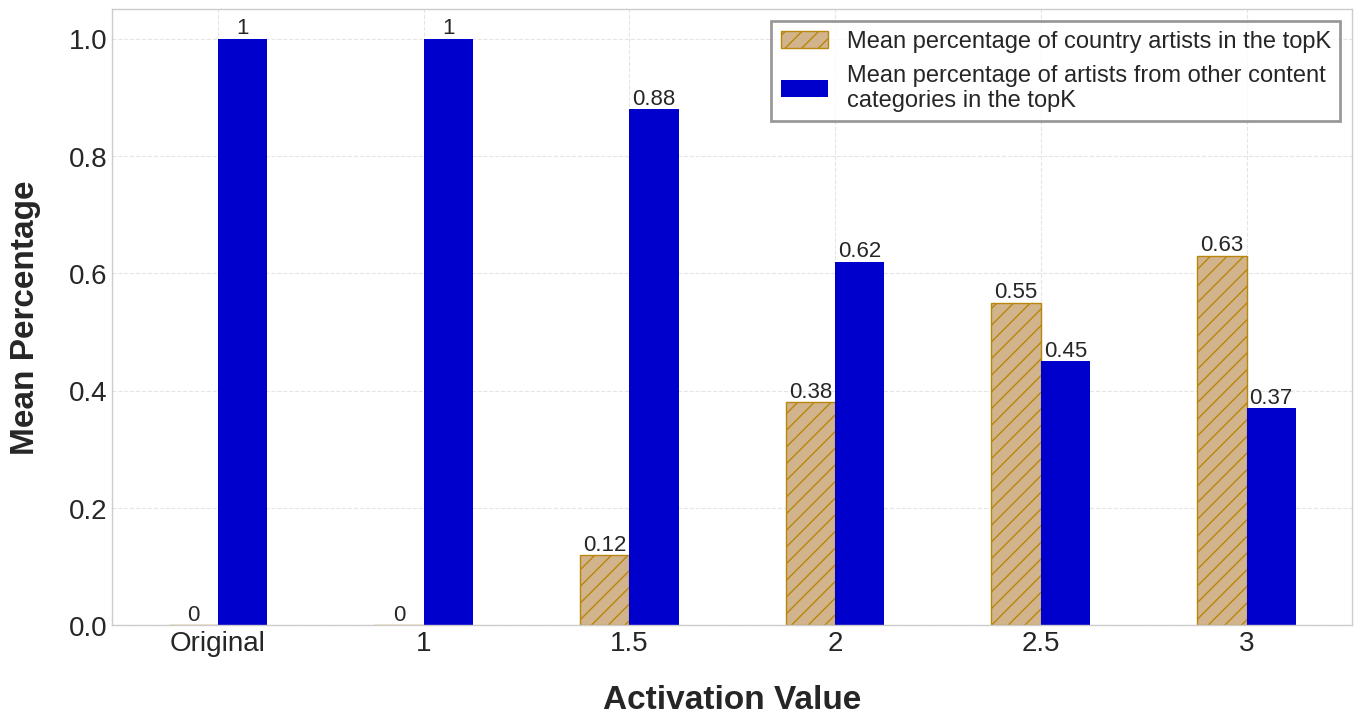

In [ ]:
fig, (ax1) = plt.subplots(1,1, figsize=(16, 8))


# new/curr/test genre:
a = [round(ob,2) for ob in meanTestGenreMoviesInTopK4DemoGroup]
r1=ax1.bar(neuron_levels, a, color='tan', width= 0.12, hatch = '//', edgecolor = 'darkgoldenrod')
ax1.bar_label(r1,fontsize=16)

b = [round(ob,2) for ob in meanOldGenreMoviesInTopK4DemoGroup]
r2=ax1.bar([0.62, 1.12, 1.62, 2.12, 2.62, 3.12], b, color='mediumblue', width= 0.12)
ax1.bar_label(r2,fontsize=16)

ax1.set_xlabel('Activation Value', labelpad=20,weight='bold',fontsize=24)
# ax1.set_xlabel('"Country artists" Neuron Activation Value', labelpad=20,weight='bold',fontsize=24)

ax1.set_ylabel('Mean Percentage', labelpad=20,weight='bold',fontsize=24)
ax1.grid(True, linestyle='--', alpha=0.5)

ax1.set_xticks([0.56, 1.06, 1.56, 2.06, 2.56, 3.06])

ax1.tick_params(axis='both', labelsize=17)
ax1.set_xticklabels(neuron_levels_block,fontsize=20)
ax1.set_yticklabels([0.0, 0.2, 0.4,0.6,0.8,1.0],fontsize=20)
leg = plt.legend([f'Mean percentage of {genre_expose} artists in the topK', f'Mean percentage of artists from other content\ncategories in the topK'],frameon=True, loc='upper right', fontsize=17, fancybox=False)
frame = leg.get_frame()
frame.set_edgecolor('grey')
frame.set_linewidth(2)






 ## use case 3- Post hoc content suppression

generate new audience

In [ ]:
'''find the group'''
'''list of users that watched movies of certain genre, sorted by the number of
movies of the certain genre wrt the total number of movies ranked by the user'''

usersGroup = generate_users_test_group('hip_hop', N, autoencoder)
usersGroup

,percentage of Horror movies
3800,0.978571
1356,0.971751
1918,0.927273
5727,0.870968
1276,0.837838
5595,0.754808
304,0.745223
2701,0.731707
1930,0.709302
3997,0.700617


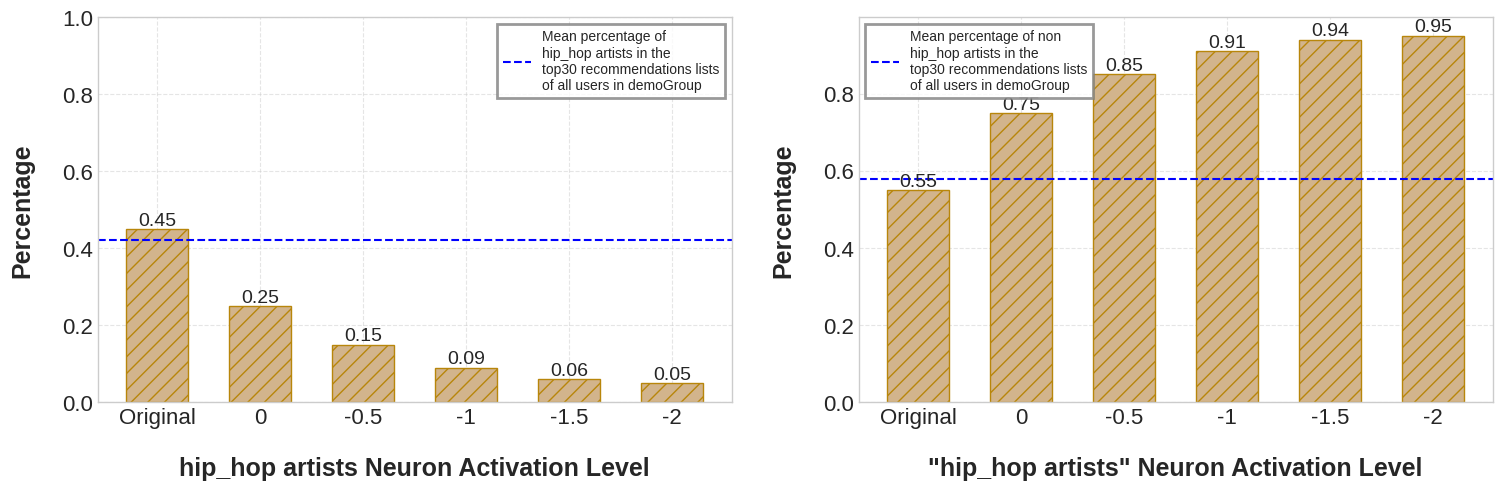

In [ ]:
movie_num2 = 30
meanTestGenreMoviesInTopK4DemoGroup_orig = []
meanTestGenreMoviesInTopK4DemoGroup = []
meanOldGenreMoviesInTopK4DemoGroup_orig = []
meanOldGenreMoviesInTopK4DemoGroup = []
genresOld_percentage_all_orig = []
genresNew_percentage_all_orig = []
genresOld_percentage_all = []
genresNew_percentage_all = []
no_effect_users = []
no_effect_users_count = 0
genre_expose = 'hip_hop'


'''dealing here with orig/new results and old/new genres'''

neuron_levels = [-0.5,0,0.5,1, 1.5,2]


'''what place 'test_artist' has among all recommendations of all relevant users '''
table = pd.DataFrame(0, index=range(len(usersGroup.index)), columns=['user', 'orig rec rank', 'new rec rank'])

for level in neuron_levels:

  no_effect_users_count=0

  genresOld_percentage_all_orig=[]
  genresOld_percentage_all=[]
  genresNew_percentage_all_orig=[]
  genresNew_percentage_all = []

  for user2 in usersGroup.index:

    top_rec_user_id_orig = recommend_pq_all(user2, dataset_users, dataset_items, movie_num2)


    a_orig = df_artists_tags.iloc[top_rec_user_id_orig,:].sum()
    orig_genres_percentage_oldGenre = (movie_num2-a_orig.loc[genre_expose])/movie_num2

    orig_genres_percentage_newGenre = a_orig.loc[genre_expose]/movie_num2
    genresOld_percentage_all_orig.append(orig_genres_percentage_oldGenre)
    genresNew_percentage_all_orig.append(orig_genres_percentage_newGenre)



    # new/ current results: for old and new/test/curr genres:

    # modified users
    x2 = np.array(np.array(dataset_users[user2]))
    x2, info2 = autoencoder.preprocess(x2)
    curr_latents2 = latents_all_usr[user2].clone()

    min_val2 = curr_latents2.min()
    max_val2 = curr_latents2.max()
    curr_latents2 = (curr_latents2 - min_val2) / (max_val2 - min_val2 + 1e-8)  # Normalize to [0,1]



    if level != -0.5:
      curr_latents2[38]=level*(-1)


    curr_latents2= curr_latents2 * (max_val2 - min_val2) + min_val2
    recons_user2 = autoencoder.decode(curr_latents2,info)

    df_user_emb_copy2= dataset_users.clone()
    df_user_emb_copy2[user2,:] = recons_user2.detach()

    top_rec_user_id_new2 = recommend_pq_all(user2, df_user_emb_copy2, dataset_items, movie_num2)


    a2 = df_artists_tags.iloc[top_rec_user_id_new2,:].sum()

    curr_genres_percentage_oldGenre = (movie_num2-a2.loc[genre_expose])/movie_num2
    curr_genres_percentage_newGenre = a2.loc[genre_expose]/movie_num2

    # TAKE OUT USERS WITH 0 INFLUENCE USING THE CURRENT LEVEL, I.E- USERS THAT AFTER THE MODIFICATION HAVE 0 MOVIES OF TEST_GENRE
    # if curr_genres_percentage_newGenre == 0:
    #   no_effect_users_count+=1
    #   # print(f'zeros influence {user2}')
    #   continue
    # print(user2)
    genresOld_percentage_all.append(curr_genres_percentage_oldGenre)
    genresNew_percentage_all.append(curr_genres_percentage_newGenre)
    # print(f'num of horror movies:{curr_genres_percentage_newGenre*movie_num2} for user {user2}')

    #--------------------------------------------------------------------------------------

  # each item in the list represents the averaged percentage of movies of test_genre in the topK recommendations list of all users in demoGroup
  #  new/curr/test genre:
  #orig results for new genre:
  meanTestGenreMoviesInTopK4DemoGroup_orig.append(sum(genresNew_percentage_all_orig)/len(genresNew_percentage_all_orig))

  #new results for new gennres:
  meanTestGenreMoviesInTopK4DemoGroup.append(sum(genresNew_percentage_all)/len(genresNew_percentage_all))


  #  old genre:
  # orig results for old genre:
  meanOldGenreMoviesInTopK4DemoGroup_orig.append(sum(genresOld_percentage_all_orig)/len(genresOld_percentage_all_orig))

  # new results for old genre:
  meanOldGenreMoviesInTopK4DemoGroup.append(sum(genresOld_percentage_all)/len(genresOld_percentage_all))

  # number of users we didnt influence to watch more test_genre movies
  no_effect_users.append(no_effect_users_count)


neuron_levels_names = neuron_levels.copy()
neuron_levels_names[0] = 'orig'


# IF WE'RE TALKING ABOUT BLOCKIING- ADD THIS REPLACE WITH neuron_levels_names
neuron_levels_block = neuron_levels.copy()
neuron_levels_block = [item* (-1) for item in neuron_levels_block]
neuron_levels_block[0] = 'Original'


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

# new/curr/test genre:
a = [round(ob,2) for ob in meanTestGenreMoviesInTopK4DemoGroup]
r1=ax1.bar(neuron_levels, a, color='tan', width= 0.3, hatch='//', edgecolor = 'darkgoldenrod')
ax1.bar_label(r1,fontsize=14)
ax1.axhline(y=meanTestGenreMoviesInTopK4DemoGroup_orig[0], color='blue', linestyle='--')
ax1.set_xlabel(f'{genre_expose} artists Neuron Activation Level', labelpad=20,weight='bold',fontsize=18)
ax1.set_ylabel('Percentage', labelpad=20,weight='bold',fontsize=18)
ax1.grid(True, linestyle='--', alpha=0.5)

ax1.set_xticks(neuron_levels)
ax1.set_yticks([0.0, 0.2, 0.4,0.6,0.8,1.0])

ax1.tick_params(axis='both', labelsize=16)
ax1.set_xticklabels(neuron_levels_block,fontsize=16)
ax1.set_yticklabels([0.0, 0.2, 0.4,0.6,0.8,1.0],fontsize=16)
leg = ax1.legend([f'Mean percentage of\n{genre_expose} artists in the\ntop{movie_num2} recommendations lists\nof all users in demoGroup'],frameon=True, loc='upper right', fontsize=10, fancybox=False)

frame = leg.get_frame()
frame.set_edgecolor('grey')
frame.set_linewidth(2)



# old genre:
b = [round(ob,2) for ob in meanOldGenreMoviesInTopK4DemoGroup]
r2=ax2.bar(neuron_levels, b, color='tan', width= 0.3, hatch='//', edgecolor = 'darkgoldenrod')
ax2.bar_label(r2,fontsize=14)
ax2.axhline(y=meanOldGenreMoviesInTopK4DemoGroup_orig[0], color='blue', linestyle='--')
ax2.set_xlabel(f'"{genre_expose} artists" Neuron Activation Level', labelpad=20,weight='bold',fontsize=18)
ax2.set_ylabel('Percentage', labelpad=20,weight='bold',fontsize=18)

ax2.grid(True, linestyle='--', alpha=0.5)
ax2.tick_params(axis='both', labelsize=16)
ax2.set_xticks(neuron_levels)
ax2.set_xticklabels(neuron_levels_block,fontsize=16)
leg = ax2.legend([f'Mean percentage of non\n{genre_expose} artists in the\ntop{movie_num2} recommendations lists\nof all users in demoGroup'],frameon=True, loc='upper left', fontsize=10, fancybox=False)

frame = leg.get_frame()
frame.set_edgecolor('grey')
frame.set_linewidth(2)


table

/tmp/ipython-input-235455476.py:26: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



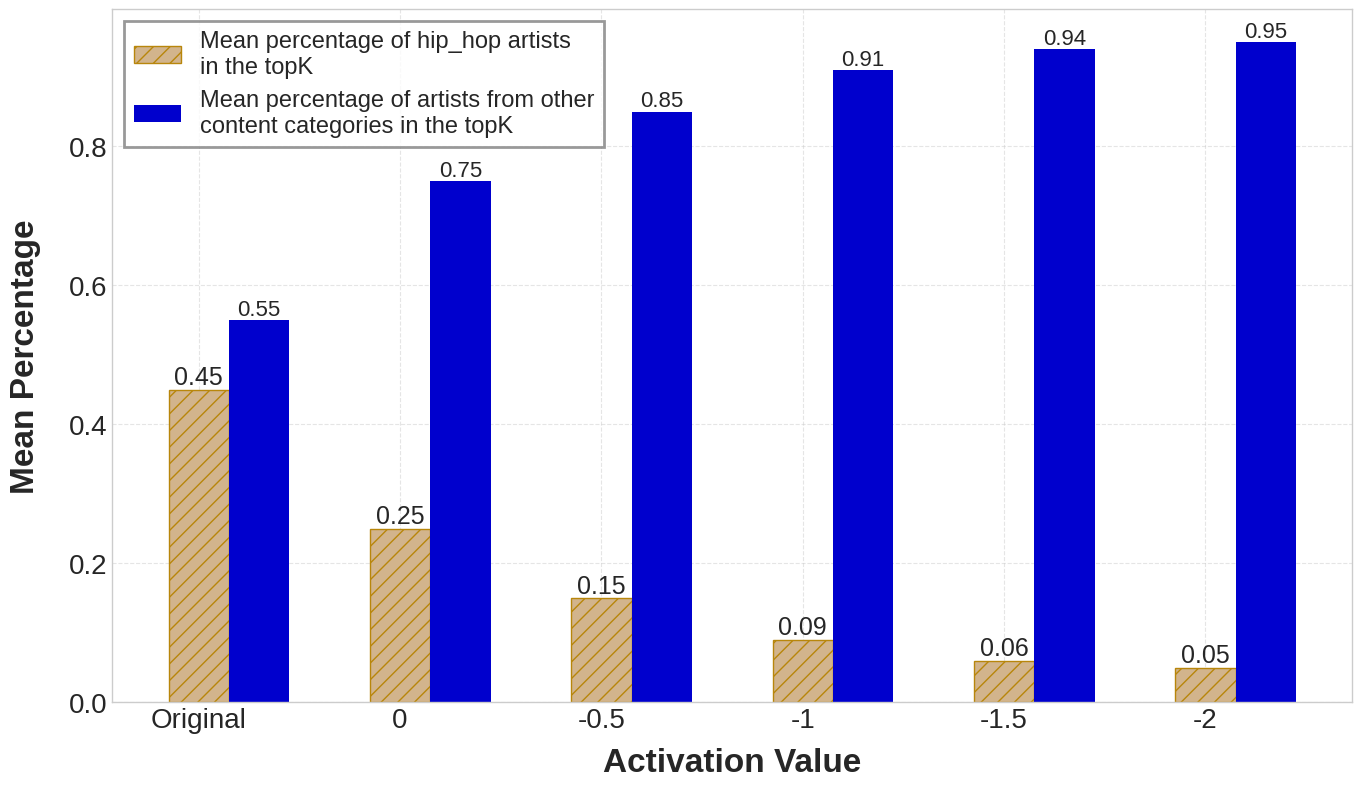

In [ ]:
fig, (ax1) = plt.subplots(1,1, figsize=(16, 9))


a = [round(ob,2) for ob in meanTestGenreMoviesInTopK4DemoGroup]
r1=ax1.bar(neuron_levels, a, color='tan', width= 0.15, hatch = '//', edgecolor = 'darkgoldenrod')
ax1.bar_label(r1,fontsize=18)

b = [round(ob,2) for ob in meanOldGenreMoviesInTopK4DemoGroup]
r2=ax1.bar([-0.35,0.15,0.65, 1.15, 1.65,2.15], b, color='mediumblue', width= 0.15)
ax1.bar_label(r2,fontsize=16)

ax1.set_xlabel('Activation Value', labelpad=10,weight='bold',fontsize=24)
ax1.set_ylabel('Mean Percentage', labelpad=20,weight='bold',fontsize=24)
ax1.grid(True, linestyle='--', alpha=0.5)



ax1.tick_params(axis='both', labelsize=20)
ax1.set_xticks(neuron_levels)
ax1.set_xticklabels(neuron_levels_block,fontsize=20)
ax1.set_yticklabels([0.0, 0.2, 0.4,0.6,0.8,1.0],fontsize=20)
leg = plt.legend([f'Mean percentage of {genre_expose} artists\nin the topK', f'Mean percentage of artists from other\ncontent categories in the topK'],frameon=True, loc='upper left', fontsize=17, fancybox=False)

frame = leg.get_frame()
frame.set_edgecolor('grey')
frame.set_linewidth(2)






-

-

# MF SAE loss term

test the rank correlation scores using RBO & Kentall Tau wrt prediction level loss term

load autoencoder if needed

In [ ]:
model_name_test = 'SAE_MF_loss_weight2'
# Initialize a new model instance with the same architecture
autoencoder = torch.load(Path(export_dir,f'models/lastFM/others/MF/{model_name_test}.pth'), weights_only  = False)

# test_subset = autoencoder.test_subset_ind
test_subset_users = autoencoder.test_subset_users_ind
test_subset_items = autoencoder.test_subset_items_ind


train_subset_users = [i for i in user_artist_matrix.index if i not in test_subset_users]

interaction_embeddings=dataset_users[train_subset_users]

In [ ]:
latents_pre_act_items, latents_items, reconstructions_items = autoencoder(dataset_items)
latents_pre_act_users, latents_users, reconstructions_users = autoencoder(dataset_users)

latents_users=latents_users.detach().clone()
latents_items=latents_items.detach().clone()

avg_ms_score= ms_score_new(df_cosine_sim_matrix, latents_items)

reconstructions_users=reconstructions_users.detach().clone()
reconstructions_items=reconstructions_items.detach().clone()



users_ind= autoencoder.test_subset_users_ind

lists_compare_table = pd.DataFrame(0, index=users_ind, columns=['RBO Score', 'Kendall Tau Score'])


for user in lists_compare_table.index:

  top_rec_user_id_orig = recommend_pq(user, dataset_users, dataset_items, 30)
  top_rec_user_id_rec  = recommend_pq(user, reconstructions_users, reconstructions_items, 30)    # top_rec_user_id_rec = rec_gen(movie_num, user, df_b_u_emb, df_b_i_emb, a_, b_)

  lists_compare_table.loc[user,'RBO Score'] = rbo(top_rec_user_id_orig[user], top_rec_user_id_rec)
  lists_compare_table.loc[user,'Kendall Tau Score'] = kendall_tau(top_rec_user_id_orig[user], top_rec_user_id_rec)

print(f'{round(float(lists_compare_table.mean().iloc[0]),6)} | {round(float(lists_compare_table.mean().iloc[1]),6)}')
print(f'averaged MS score: {avg_ms_score}')